## Logistic Regression Sklearn Deployment
### 1. Import packages and load data

In [1]:
import seaborn as sns
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, learning_curve

import sys
sys.path.append("../src")
import utils

In [2]:
df = utils.load_data('../data/raw/advertising.csv')
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.950,35,"61,833.900",256.090,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.230,31,"68,441.850",193.770,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.470,26,"59,785.940",236.500,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.150,29,"54,806.180",245.890,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.370,35,"73,889.990",225.580,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


### 2. Data pre-processing
- Visualize data
- Split data into training, cross validation and test set

In [3]:
X_features = ['Age', 'Area Income'] #, 'Daily Internet Usage'] #, 'Male']
X = df[X_features]
y = df['Clicked on Ad']

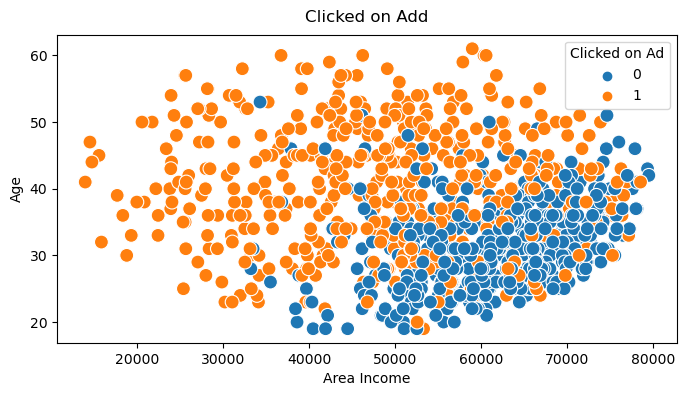

In [4]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x='Area Income', y='Age', hue='Clicked on Ad', data=df, s=100)
plt.title("Clicked on Add", y=1.015)
plt.ylabel("Age")
ax = plt.gca()

In [5]:
# train test split
x_train, x_, y_train, y_ = train_test_split(X, y, test_size=0.40, random_state=80)  # Get 60% of the dataset as the training set
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=80)  # Split 40% subset into cross validation, test set
# data standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)  # Compute the mean and standard deviation of the training set then transform it


### 3. Train model with SGDClassifier
- Train model, report training and cross validation MSE
- Choose polynomial feature

In [6]:
clf_model = SGDClassifier(loss='log_loss', max_iter=100000, n_iter_no_change=1000)
clf_model.fit(X_train_scaled, y_train)

print(f"Number of iterations completed: {clf_model.n_iter_}, number of weight updates: {clf_model.t_}")
b_norm = clf_model.intercept_
w_norm = clf_model.coef_
print(f"Model parameters: \n\tw: {w_norm}, b:{b_norm}")

yhat = clf_model.predict(X_train_scaled)
print(f"Training MSE: {mean_squared_error(y_train, yhat) / 2}")
X_cv_scaled = scaler.transform(x_cv)  # Scale the cross validation set
yhat = clf_model.predict(X_cv_scaled)  # Feed the scaled cross validation set
print(f"Cross validation MSE: {mean_squared_error(y_cv, yhat) / 2}")

Number of iterations completed: 1189, number of weight updates: 713401.0
Model parameters: 
	w: [[ 1.40323215 -1.30290945]], b:[0.21479486]
Training MSE: 0.09916666666666667
Cross validation MSE: 0.0925


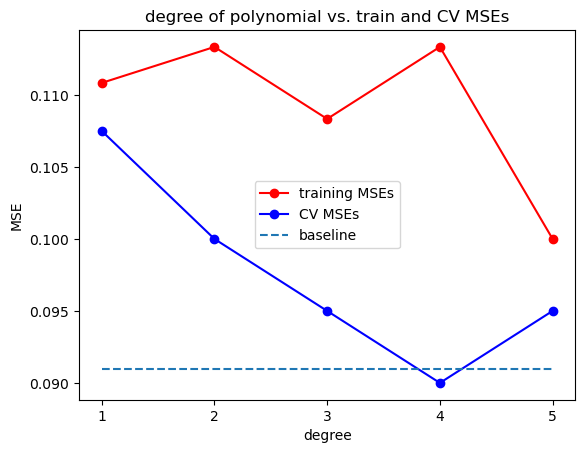

Lowest CV MSE is found in the model with degree=4
Corresponding training MSE: 0.11
Corresponding cross validation MSE: 0.09


In [7]:
s_model_n = SGDClassifier(loss='log_loss')
s_degrees, s_train_mses, s_cv_mses, s_scalers, s_models = utils.train_poly(s_model_n, X_train_scaled, y_train, X_cv_scaled, y_cv)
utils.plot_train_cv_mses(s_degrees, s_train_mses, s_cv_mses, baseline=0.091)

degree = np.argmin(s_cv_mses) + 1
print(f"Lowest CV MSE is found in the model with degree={degree}")
print(f"Corresponding training MSE: {s_train_mses[degree-1]:.2f}")
print(f"Corresponding cross validation MSE: {s_cv_mses[degree-1]:.2f}")

### 4. Train model with LogisticRegression
- Train model, report training and cross validation MSE
- Choose polynomial feature

In [8]:
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)

print(f"Number of iterations completed: {lr_model.n_iter_}")
b_norm = lr_model.intercept_
w_norm = lr_model.coef_
print(f"Model parameters:   \n\tw: {w_norm}, b:{b_norm}")

y_pred = lr_model.predict(X_train_scaled)
print(f"Training MSE: {mean_squared_error(y_train, y_pred) / 2}")

yhat = lr_model.predict(X_cv_scaled)  # Feed the scaled cross validation set
print(f"Cross validation MSE: {mean_squared_error(y_cv, yhat) / 2}")

Number of iterations completed: [8]
Model parameters:   
	w: [[ 1.38258257 -1.26639644]], b:[0.18886723]
Training MSE: 0.09833333333333333
Cross validation MSE: 0.0925


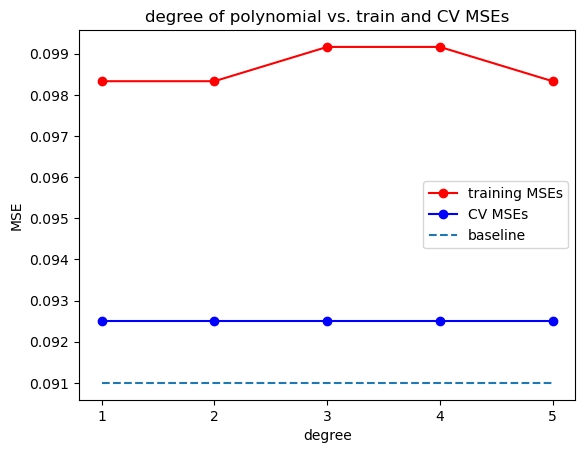

Lowest CV MSE is found in the model with degree=1
Corresponding training MSE: 0.10
Corresponding cross validation MSE: 0.09


In [9]:
lr_model_n = LogisticRegression()
lr_degrees, lr_train_mses, lr_cv_mses, lr_scalers, lr_models = utils.train_poly(lr_model_n, X_train_scaled, y_train, X_cv_scaled, y_cv)
utils.plot_train_cv_mses(lr_degrees, lr_train_mses, lr_cv_mses, baseline=0.091)

degree = np.argmin(lr_cv_mses) + 1
print(f"Lowest CV MSE is found in the model with degree={degree}")
print(f"Corresponding training MSE: {lr_train_mses[degree-1]:.2f}")
print(f"Corresponding cross validation MSE: {lr_cv_mses[degree-1]:.2f}")


### 5. Model selection
- Choose model and polynominal features
- Report test MSE

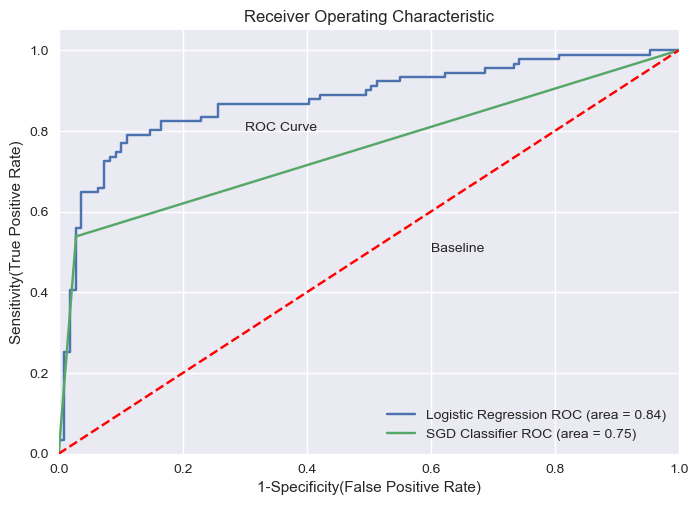

In [17]:
# Add the models to the list that you want to view on the ROC plot
models = [{'label': 'Logistic Regression', 'model': LogisticRegression()},
{'label': 'SGD Classifier', 'model': SGDClassifier(loss='log_loss', max_iter=100000, n_iter_no_change=1000)}]
utils.plot_roc(models, x_train, y_train, x_test, y_test)

In [11]:
# Add polynomial features to the test set
print('After comparing cross validation MSE and ROC, choose Logistic Regression model')
degree = np.argmin(lr_cv_mses) + 1
poly = PolynomialFeatures(degree, include_bias=False)
X_test_mapped = poly.fit_transform(x_test)

# Scale the test set
X_test_mapped_scaled = lr_scalers[degree-1].transform(X_test_mapped)

# Compute the test MSE
yhat = lr_models[degree-1].predict(X_test_mapped_scaled)
test_mse = mean_squared_error(y_test, yhat) / 2

print(f"Training MSE: {lr_train_mses[degree-1]:.2f}")
print(f"Cross Validation MSE: {lr_cv_mses[degree-1]:.2f}")
print(f"Test MSE: {test_mse:.2f}")

After comparing cross validation MSE and ROC, choose Logistic Regression model
Training MSE: 0.10
Cross Validation MSE: 0.09
Test MSE: 0.23


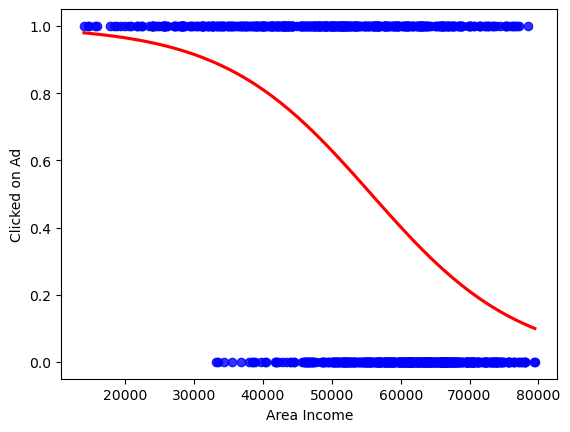

In [12]:
# plot logistic regression curve with black points and red line
sns.regplot(x=df['Area Income'], y=df['Clicked on Ad'], data=df, logistic=True, ci=None,
            scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.show()

### 6. Learning curve

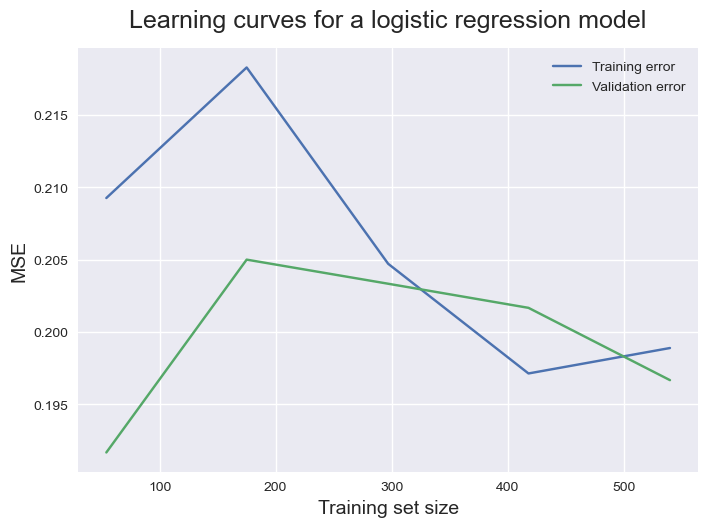

In [13]:
# train_sizes = [1, 200, 400, 600, 800]
train_sizes, train_scores, validation_scores = learning_curve(estimator = LogisticRegression(),
                                                              X = X_train_scaled, y = y_train, #train_sizes = train_sizes,
                                                              cv = 10, scoring = 'neg_mean_squared_error', shuffle=True)

train_scores_mean = -train_scores.mean(axis=1)
validation_scores_mean = -validation_scores.mean(axis=1)

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error') 
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a logistic regression model', fontsize = 18, y = 1.03)
plt.legend(); plt.show()